In [ ]:
from google.colab import files

# Upload the fer2013 file
uploaded = files.upload()


Saving archive.zip to archive.zip


In [ ]:
# Extract the zip file
import zipfile


with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Specify the path for the train and test folders
train_folder = '/content/train'
test_folder = '/content/test'

# Function to extract pixel values from an image
def extract_pixels(image_path):
    image = keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    pixels = keras.preprocessing.image.img_to_array(image) / 255.0
    return pixels

# Load and preprocess the data
train_data = []
train_labels = []
test_data = []
test_labels = []

for subdir in os.listdir(train_folder):
    subdir_path = os.path.join(train_folder, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            if filename.endswith('.jpg'):
                image_path = os.path.join(subdir_path, filename)
                pixels = extract_pixels(image_path)
                train_data.append(pixels)
                train_labels.append(subdir)

for subdir in os.listdir(test_folder):
    subdir_path = os.path.join(test_folder, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            if filename.endswith('.jpg'):
                image_path = os.path.join(subdir_path, filename)
                pixels = extract_pixels(image_path)
                test_data.append(pixels)
                test_labels.append(subdir)

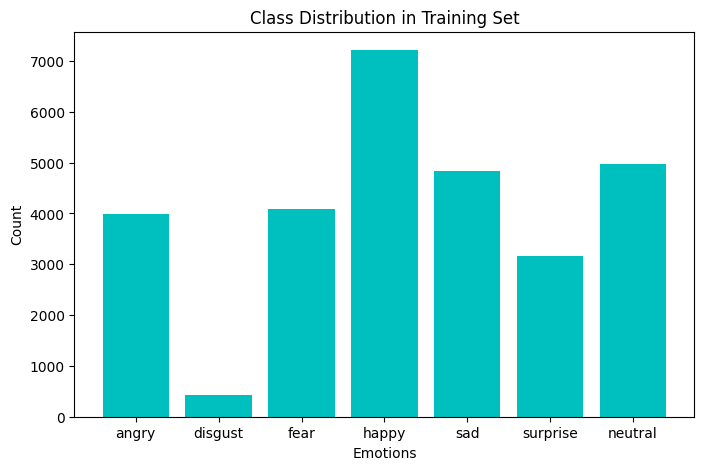

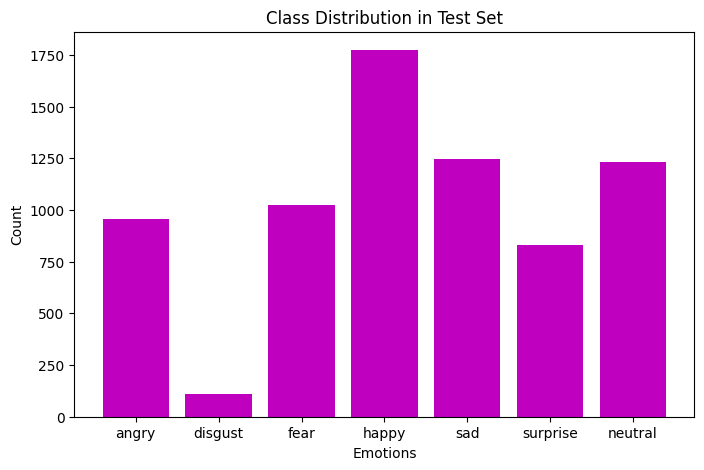

In [ ]:


# Get unique labels and their counts from the training set
train_labels_unique, train_labels_counts = np.unique(train_labels, return_counts=True)

# Get unique labels and their counts from the test set
test_labels_unique, test_labels_counts = np.unique(test_labels, return_counts=True)

# Define all possible emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Create a dictionary to map emotion labels to integer values
label_to_int = {str(label): i for i, label in enumerate(emotion_labels)}

# Map the unique labels to integer values
train_labels_int = np.array([label_to_int[str(label)] for label in train_labels_unique])
test_labels_int = np.array([label_to_int[str(label)] for label in test_labels_unique])

# Create an array with the counts for all possible emotion labels
train_labels_counts_all = np.zeros(len(emotion_labels), dtype=int)
train_labels_counts_all[train_labels_int] = train_labels_counts

test_labels_counts_all = np.zeros(len(emotion_labels), dtype=int)
test_labels_counts_all[test_labels_int] = test_labels_counts

# Set the x-tick positions for the histogram
x_ticks_train = np.arange(len(emotion_labels))
x_ticks_test = np.arange(len(emotion_labels))

# Plot the class distribution in the training set
plt.figure(figsize=(8, 5))
plt.bar(x_ticks_train, train_labels_counts_all, color='c')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.xticks(x_ticks_train, emotion_labels)
plt.show()

# Plot the class distribution in the test set
plt.figure(figsize=(8, 5))
plt.bar(x_ticks_test, test_labels_counts_all, color='m')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Class Distribution in Test Set')
plt.xticks(x_ticks_test, emotion_labels)
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Convert labels to integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

datagen.fit(X_train)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the model architecture
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [ ]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Implement learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Train the model with augmented data
history = model.fit(
    datagen.flow(np.array(X_train), keras.utils.to_categorical(y_train), batch_size=64),
    steps_per_epoch=len(X_train) / 64,
    epochs=100,
    validation_data=(np.array(X_val), keras.utils.to_categorical(y_val)),
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/100
358/358 [==============================] - 33s 49ms/step - loss: 2.2013 - accuracy: 0.2346 - val_loss: 1.8906 - val_accuracy: 0.2473 - lr: 0.0010
Epoch 2/100
358/358 [==============================] - 13s 36ms/step - loss: 1.7448 - accuracy: 0.3241 - val_loss: 1.5201 - val_accuracy: 0.4077 - lr: 0.0010
Epoch 3/100
358/358 [==============================] - 14s 38ms/step - loss: 1.5841 - accuracy: 0.3798 - val_loss: 1.4219 - val_accuracy: 0.4572 - lr: 0.0010
Epoch 4/100
358/358 [==============================] - 13s 36ms/step - loss: 1.4828 - accuracy: 0.4270 - val_loss: 1.4543 - val_accuracy: 0.4349 - lr: 0.0010
Epoch 5/100
358/358 [==============================] - 14s 38ms/step - loss: 1.4095 - accuracy: 0.4577 - val_loss: 1.4524 - val_accuracy: 0.4559 - lr: 0.0010
Epoch 6/100
358/358 [==============================] - 13s 35ms/step - loss: 1.3543 - accuracy: 0.4816 - val_loss: 1.2533 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 7/100
358/358 [==============================]

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(np.array(test_data), keras.utils.to_categorical(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


225/225 [==============================] - 1s 4ms/step - loss: 1.0106 - accuracy: 0.6142
Test Loss: 1.0105681419372559
Test Accuracy: 0.6142379641532898


In [ ]:
# Save the model
model.save('trained_model.h5')

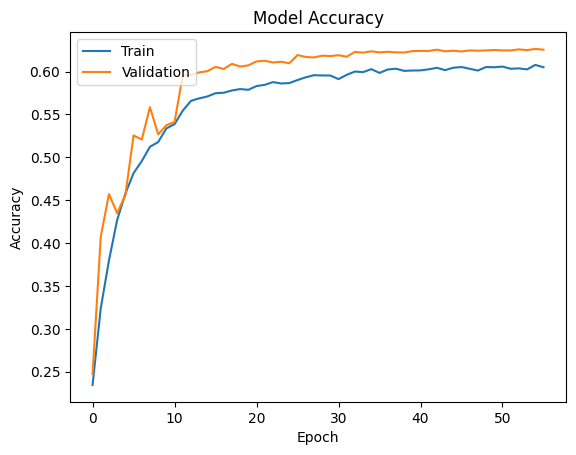

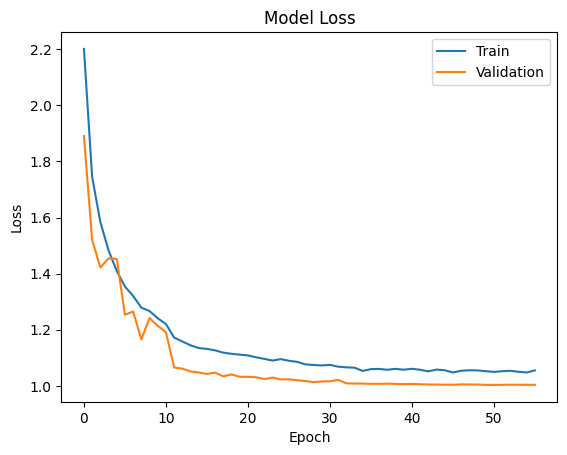

In [ ]:
#Plot the learning curves for training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate the confusion matrix
y_test_pred = np.argmax(model.predict(np.array(test_data)), axis=-1)
cm = confusion_matrix(test_labels, y_test_pred)


225/225 [==============================] - 1s 3ms/step


In [ ]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

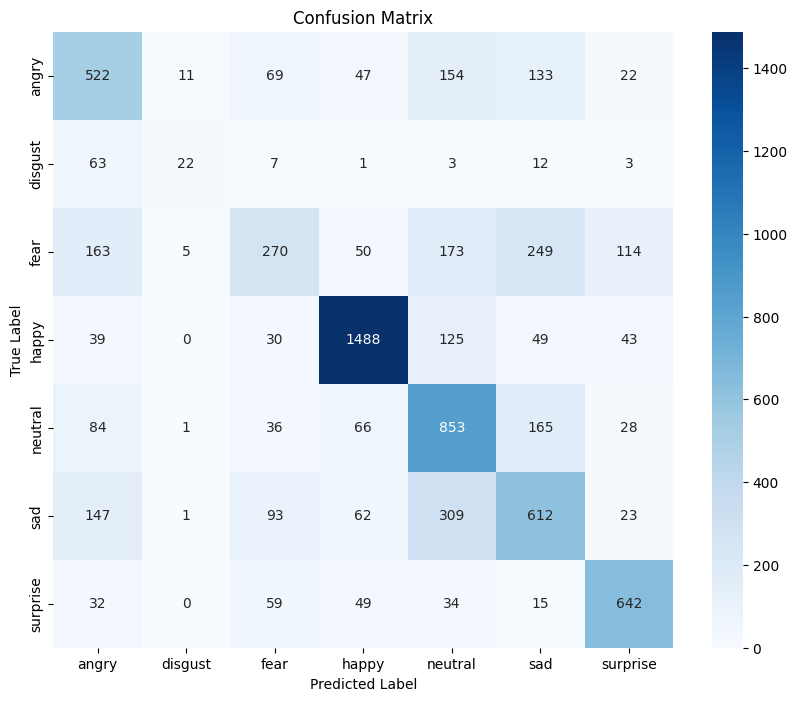

In [ ]:
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()